# **Initialization**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Filepath init
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

# **Exercise 1**

In [11]:
# Install openpyxl if not already installed
%pip install openpyxl

# Extracting the data and formatting the dataset
monthly_return = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
monthly_return_melted = monthly_return.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
monthly_return_melted.rename(columns={'NAME': 'Name'}, inplace=True)

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Extracting the country-region dataset and merging it to the previous one
static = pd.read_excel(filepath + 'Static.xlsx')
df_ex1 = pd.merge(monthly_return_melted, static, on=['Name','ISIN'], how='outer')

In [13]:
# Filtering the rows of interest
df_ex1 = df_ex1[df_ex1['Region'] == 'PAC']
df_ex1 = df_ex1[(pd.to_datetime(df_ex1['year']) >= '2013-12-31') & (pd.to_datetime(df_ex1['year']) <= '2023-12-31')]

In [14]:
# Sorting to facilitate comprehension
df_ex1.sort_values(by=['Name', 'year'], inplace=True)

In [15]:
# New col with percentage change between two months
df_ex1['individual_monthly_return'] = df_ex1.groupby('Name')['monthly_return'].pct_change()

In [16]:
df_ex1

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
347166,77 BANK,JP3352000008,2013-12-31,0.68,JP,PAC,NaN
347167,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412
347168,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606
347169,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258
347170,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000
...,...,...,...,...,...,...,...
249132,YUEXIU PROPERTY COMPANY,HK0000745908,2023-08-31,62.82,HK,PAC,-0.055906
249133,YUEXIU PROPERTY COMPANY,HK0000745908,2023-09-29,58.43,HK,PAC,-0.069882
249134,YUEXIU PROPERTY COMPANY,HK0000745908,2023-10-31,54.23,HK,PAC,-0.071881
249135,YUEXIU PROPERTY COMPANY,HK0000745908,2023-11-30,47.52,HK,PAC,-0.123732


In [17]:
# Dropping the 31.12.2013 rows (not included in our timeframe but necessary for the pct_change of 31.12.2014)
df_ex1 = df_ex1[pd.to_datetime(df_ex1['year']).dt.year >= 2014]

In [18]:
# Filtering by non missing escores (2013-2024) complete dataset to allow comparisons
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')
melted_escore = escore.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="escore")
melted_escore.rename(columns={'NAME': 'Name'}, inplace=True)
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')
escore_interest = pd.merge(melted_escore, static, how='outer')
escore_interest = escore_interest[(escore_interest['year'] >= '2013-01-01') & (melted_escore['year'] <= '2024-12-31')]
escore_interest = escore_interest[escore_interest['Region'] == 'PAC']

In [19]:
filtered = escore_interest.groupby('ISIN')['escore'].count().reset_index()
filtered = filtered[filtered['escore'] == 11]

In [20]:
interest_companies = filtered['ISIN'].tolist()

In [21]:
# Filtering df_ex1 to include only non missing escores
df_ex1 = df_ex1[df_ex1['ISIN'].isin(interest_companies)]

In [22]:
df_ex1[df_ex1['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
387751,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,JP,PAC,0.0
387752,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,JP,PAC,0.0
387753,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,JP,PAC,0.0
387754,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,JP,PAC,0.0
373862,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,JP,PAC,0.0


In [23]:
# Individual handling of the 5 missings
df_ex1['individual_monthly_return'].loc[592512] = -1.
df_ex1['individual_monthly_return'].loc[592513] = np.nan
df_ex1['individual_monthly_return'].loc[592514] = np.nan
df_ex1['individual_monthly_return'].loc[592515] = np.nan
df_ex1['individual_monthly_return'].loc[698819] = -1.


In [24]:
# Creation of the averaged returns and their std + merge
annualization_mean = df_ex1.groupby('Name')['individual_monthly_return'].mean()
annualization_mean = pd.DataFrame(annualization_mean)
annualization_mean.rename(columns={'individual_monthly_return': 'monthly_mean'}, inplace=True)

annualization_var = df_ex1.groupby('Name')['individual_monthly_return'].std()
annualization_var = pd.DataFrame(annualization_var)
annualization_var.rename(columns={'individual_monthly_return': 'monthly_std'}, inplace=True)

annualization = pd.merge(annualization_mean, annualization_var, on='Name', how='outer')

In [25]:
# Creation of annualized cols
annualization['annualized_mean'] = annualization['monthly_mean'] * 12
annualization['annualized_std'] = annualization['monthly_std'] * np.sqrt(12)

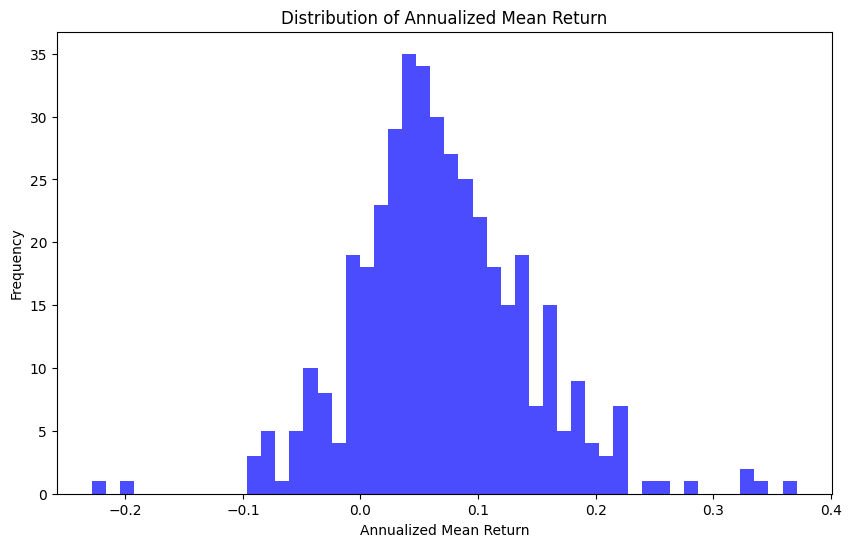

In [26]:
# Annualized mean histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_mean'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Mean Return')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Mean Return')
plt.show()

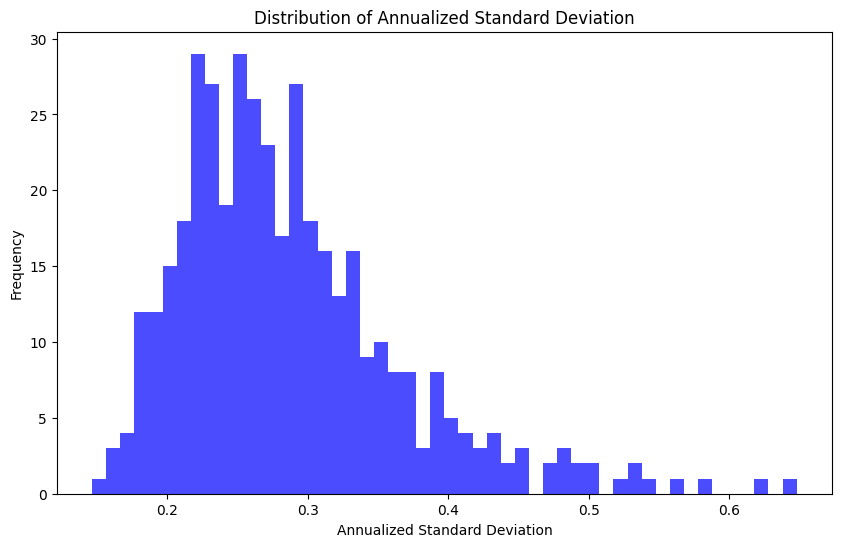

In [27]:
# Annualized std histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_std'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Standard Deviation')
plt.show()

In [28]:
# Variance-covariance matrix
np.corrcoef(annualization['annualized_mean'], annualization['annualized_std'])

array([[1.        , 0.10394675],
       [0.10394675, 1.        ]])

# **Exercise 2**

In [29]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')


In [30]:
# Risk-free rates dataset
risk_free = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')
risk_free.rename(columns={'Unnamed: 0': 'year'}, inplace=True)
risk_free['year'] = pd.to_datetime(risk_free['year'], format='%Y%m')

In [31]:
# Merging the datasets
df_ex2 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex2.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex2 = pd.merge(df_ex2, static, on=['Name', 'ISIN'], how='outer')

In [32]:
# Filter region and years of interest
df_ex2 = df_ex2[df_ex2['Region'] == 'PAC']
df_ex2 = df_ex2[(df_ex2['year'] >= '2013-12-31') & (df_ex2['year'] <= '2023-12-31')]
df_ex2['year'] = pd.to_datetime(df_ex2['year'])

In [33]:
# Filter same companies as in ex1 (non missing escores from 2013 to 2024)
df_ex2 = df_ex2[df_ex2['ISIN'].isin(interest_companies)]

In [34]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region
373862,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC
387751,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC
387752,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC
387753,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC
387754,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC


In [35]:
# Returns percentage change and drop the 31.12.2013 rows
df_ex2['pct_monthly_return'] = df_ex2.groupby('Name')['monthly_return'].pct_change()
df_ex2 = df_ex2[pd.to_datetime(df_ex2['year']).dt.year >= 2014]

In [36]:
# Individual handling of the 5 missings
df_ex2['pct_monthly_return'].loc[592512] = -1.
df_ex2['pct_monthly_return'].loc[592513] = np.nan
df_ex2['pct_monthly_return'].loc[592514] = np.nan
df_ex2['pct_monthly_return'].loc[592515] = np.nan
df_ex2['pct_monthly_return'].loc[698819] = -1.


In [37]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,pct_monthly_return
373862,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,0.0
387751,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,0.0
387752,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,0.0
387753,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,0.0
387754,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,0.0


In [38]:
# Building the equally weighted portfolio
ew_pf = df_ex2.groupby('year')['pct_monthly_return'].sum().reset_index()

In [39]:
# Dividing the return by the number of assets for each month
ew_pf['ew_m_ret'] = 0
for month in df_ex2['year'].unique():
    ew_pf.loc[ew_pf['year'] == month, 'ew_m_ret'] = ew_pf.loc[ew_pf['year'] == month, 'pct_monthly_return'] / len(df_ex2[df_ex2['year'] == month]['Name'].unique())

In [40]:
# Calculate the market value share
df_ex2['mv_share'] = df_ex2['monthly_market_value'] / df_ex2.groupby('year')['monthly_market_value'].transform('sum')

In [41]:
# Weight the returns by the market value share shifted as in the exercise sheet
df_ex2['mv_return'] = df_ex2['pct_monthly_return'] * df_ex2['mv_share'].shift(1)

In [42]:
# Market value weighted portfolio
mw_pf = df_ex2.groupby('year')['mv_return'].sum().reset_index()

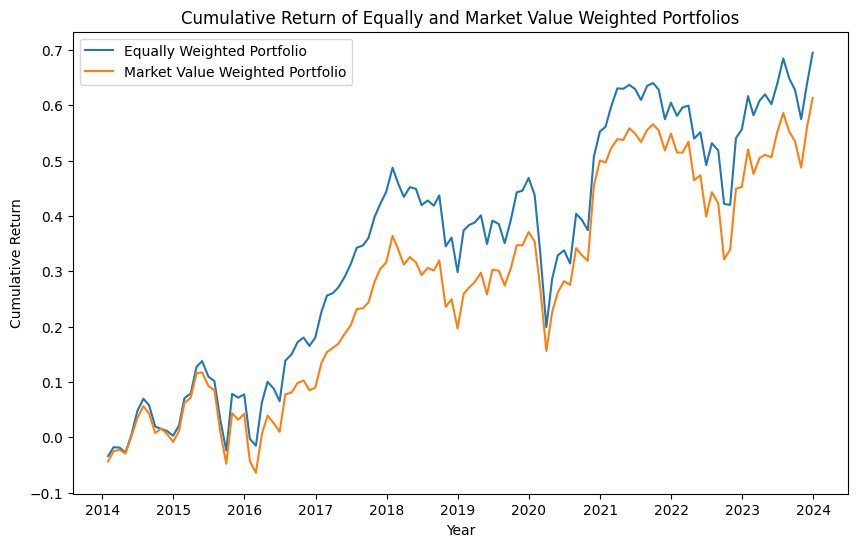

In [43]:
# Plot the monthly adapted returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(ew_pf['year'], ew_pf['ew_m_ret'].cumsum(), label='Equally Weighted Portfolio')
plt.plot(mw_pf['year'], mw_pf['mv_return'].cumsum(), label='Market Value Weighted Portfolio')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Equally and Market Value Weighted Portfolios')
plt.legend()
plt.show()

In [44]:
# Risk free rate in the given period 
risk_free = risk_free[(pd.to_datetime(risk_free['year']).dt.year >= 2014) & (pd.to_datetime(risk_free['year']).dt.year <= 2023)]
# Annualized risk free rate
ann_rf = risk_free['RF'].mean() * 12

In [45]:
# Statistics of interest Equally Weighted Portfolio
# Annualized return
ew_ann_ret = ew_pf['ew_m_ret'].mean() * 12
# Annualized std
ew_ann_std = ew_pf['ew_m_ret'].std() * np.sqrt(12)
#min return
ew_min_ret = ew_pf['ew_m_ret'].min()
#max return
ew_max_ret = ew_pf['ew_m_ret'].max()

# Statistics of interest Market Value Weighted Portfolio
# Annualized return
mw_ann_ret = mw_pf['mv_return'].mean() * 12
# Annualized std
mw_ann_std = mw_pf['mv_return'].std() * np.sqrt(12)
#min return
mw_min_ret = mw_pf['mv_return'].min()
#max return
mw_max_ret = mw_pf['mv_return'].max()


In [46]:
# Equally weighted Sharpe Ratio
ew_pf['year'] = ew_pf['year'] + pd.offsets.MonthBegin(-1)
ew_pf = pd.merge(ew_pf, risk_free, on='year', how='outer')
ew_pf['excess_ret'] = ew_pf['ew_m_ret'] - ew_pf['RF']
ew_pf['ann_exc_ret'] = ew_pf['excess_ret'] * 12
ew_sharpe = ew_pf['ann_exc_ret'].sum()/ew_ann_std
ew_sharpe

-881.470875867483

In [47]:
mw_pf

,year,mv_return
0,2014-01-31,-0.0433
1,2014-02-28,0.018391
2,2014-03-31,0.002407
3,2014-04-30,-0.006719
4,2014-05-30,0.030363
...,...,...
115,2023-08-31,-0.034065
116,2023-09-29,-0.016669
117,2023-10-31,-0.047989
118,2023-11-30,0.073096


In [48]:
# Value weighted Sharpe Ratio
mw_pf['year'] = mw_pf['year'] + pd.offsets.MonthBegin(-1)
mw_pf = pd.merge(mw_pf, risk_free, on='year', how='outer')
mw_pf['excess_ret'] = mw_pf['mv_return'] - mw_pf['RF']
mw_pf['ann_exc_ret'] = mw_pf['excess_ret'] * 12
mw_sharpe = mw_pf['ann_exc_ret'].sum()/mw_ann_std
mw_sharpe

-944.0957544774673

In [49]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069500,0.149409,-881.470876,-0.136916,0.132389
1,Market Value Weighted,0.061306,0.140540,-944.095754,-0.115458,0.135156


In [50]:
'''delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
       'TOSHIBA DEAD - DELIST.20/12/23']'''

"delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',\n       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',\n       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',\n       'LAWSON DEAD - DELIST.24/07/24',\n       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',\n       'TOSHIBA DEAD - DELIST.20/12/23']"

In [51]:
annualization = annualization.reset_index()

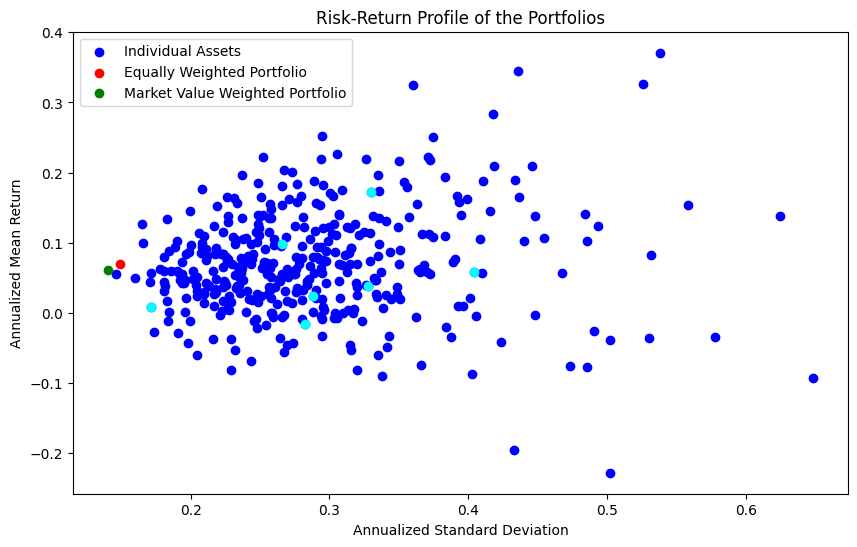

In [52]:
# Define the list of delisted companies
delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
			'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
			'CSR DEAD - DEAD.10/07/24', 
			'J S R DEAD - DELIST.25/06/24',
			'LAWSON DEAD - DELIST.24/07/24',
			'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
			'TOSHIBA DEAD - DELIST.20/12/23']

plt.figure(figsize=(10, 6))
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
plt.scatter(annualization[annualization['Name'].isin(delisted)]['annualized_std'], annualization[annualization['Name'].isin(delisted)]['annualized_mean'], color='cyan')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.show()

# **Exercise 3**

In [53]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')
# Merging the datasets
df_ex3 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex3.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex3 = pd.merge(df_ex3, static, on=['Name', 'ISIN'], how='outer')
# Filter region and years of interest
df_ex3 = df_ex3[df_ex3['Region'] == 'PAC']
df_ex3 = df_ex3[(df_ex3['year'] >= '2012-12-31') & (df_ex3['year'] <= '2023-12-31')]


In [54]:
# Filter df_ex3 to the same companies of interest as before (non missing escore from 2013 to 2024)
df_ex3 = df_ex3[df_ex3['ISIN'].isin(interest_companies)]

In [55]:
# Ensure the 'year' column in escore is datetime type
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')

# Merge the dataframes using merge_asof to align yearly escore data with monthly df_ex3 data
df_ex3 = pd.merge_asof(df_ex3.sort_values('year'), 
                                melted_escore.sort_values('year'), 
                                by=['Name', 'ISIN'], 
                                on='year', 
                                direction='backward')

In [56]:
# Returns percentage change and drop the 31.12.2012 rows
df_ex3['pct_monthly_return'] = df_ex3.groupby('Name')['monthly_return'].pct_change()
df_ex3 = df_ex3[pd.to_datetime(df_ex3['year']).dt.year >= 2013]

In [57]:
df_ex3.sort_values(by=['Name', 'year'], inplace=True)

In [58]:
df_ex3 = df_ex3[(df_ex3['year'].dt.year != 2013) & (df_ex3['year'].dt.year != 2012)]

In [59]:
df_ex3[df_ex3['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,escore,pct_monthly_return
53037,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,63.93,0.0
53412,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,63.93,0.0
53705,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,63.93,0.0
54110,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,63.93,0.0
54085,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,89.52,0.0


In [60]:
# Individual handling of the 5 missings
df_ex3['pct_monthly_return'].loc[52914] = -1.
df_ex3['pct_monthly_return'].loc[53307] = np.nan
df_ex3['pct_monthly_return'].loc[53701] = np.nan
df_ex3['pct_monthly_return'].loc[54106] = np.nan
df_ex3['pct_monthly_return'].loc[54362] = -1.


C:\Users\franc\AppData\Local\Temp\ipykernel_160280\1593166099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex3['pct_monthly_return'].loc[53307] = np.nan
C:\Users\franc\AppData\Local\Temp\ipykernel_160280\1593166099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex3['pct_monthly_return'].loc[53701] = np.nan
C:\Users\franc\AppData\Local\Temp\ipykernel_160280\1593166099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [61]:
# Create the variance-covariance matrix for pct_monthly_return
cov_matrix = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

In [62]:
# Install scipy if not already installed
%pip install scipy

from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.


In [63]:
# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [64]:
# Number of assets
num_assets = len(cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
min_variance_weights = result.x

# Display the optimal weights
#min_variance_weights

In [65]:
minvar_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
minvar_pf['minvar_w'] = min_variance_weights
minvar_pf['annualized_mean'] = minvar_pf['pct_monthly_return'] * 12
minvar_pf['annualized_std'] = minvar_pf['pct_monthly_return'].std() * np.sqrt(12)
# Annualized mean
minvar_ann_ret = (minvar_pf['annualized_mean'] * minvar_pf['minvar_w']).sum()
# Annualized std
minvar_ann_std = minvar_pf['annualized_std'].std() * np.sqrt(12)

In [66]:
# Objective function: negative portfolio return (to maximize return)
def portfolio_return(weights, returns):
    return -np.dot(weights, returns)

# Mean returns of the assets
mean_returns = df_ex3.groupby('Name')['pct_monthly_return'].mean().values

# Minimize the negative portfolio return
result_max_return = minimize(portfolio_return, init_guess, args=(mean_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights for maximum return portfolio
max_return_weights = result_max_return.x

# Display the optimal weights
# max_return_weights

In [67]:
# Calculate the annualized return of the minimum variance portfolio
minvar_ann_ret = np.sum(min_variance_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
minvar_ann_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix * 12, min_variance_weights)))

# Calculate the annualized return of the minimum variance portfolio
maxr_ann_ret = np.sum(max_return_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
maxr_ann_std = np.sqrt(np.dot(max_return_weights.T, np.dot(cov_matrix * 12, max_return_weights)))


In [68]:
# Compute the efficient frontier portofolios
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 10)
efficient_frontier = []
for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12 - target})
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_frontier.append(result.x)

In [69]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
target_ann_ret = []
target_ann_std = []

for weights in efficient_frontier:
	ann_ret = np.sum(weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12
	ann_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
	target_ann_ret.append(ann_ret)
	target_ann_std.append(ann_std)

# Convert lists to numpy arrays
target_ann_ret = np.array(target_ann_ret)
target_ann_std = np.array(target_ann_std)

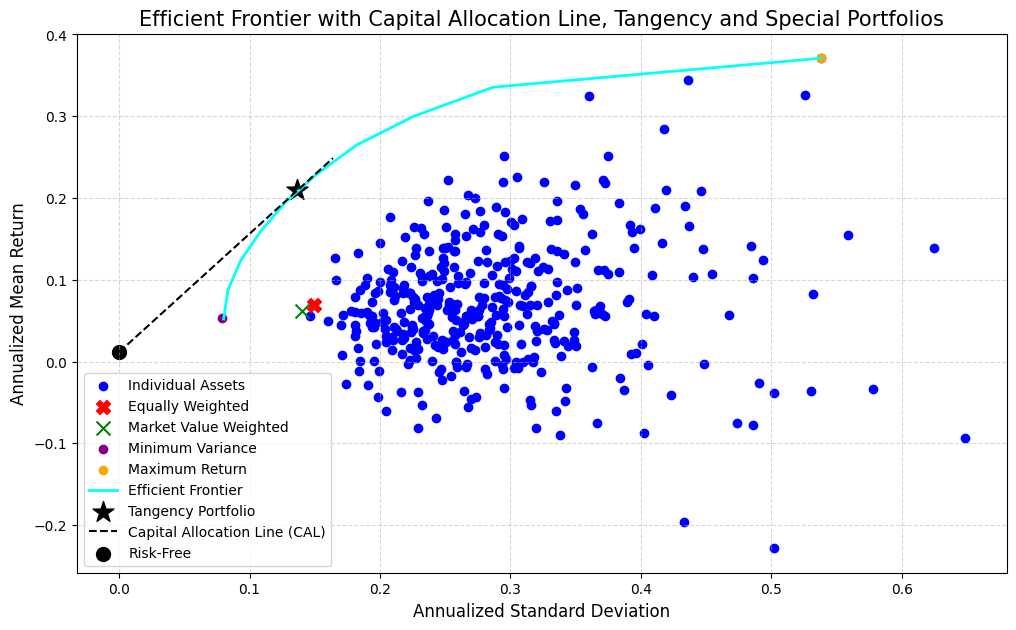

In [96]:
monthly_rf = risk_free['RF'].mean() / 100 # professor said it in the mail
ann_rf = monthly_rf * 12  # professor explicitly defined annualization as simple multiplication

# Annualized returns and covariance
mean_returns_monthly = df_ex3.groupby('Name')['pct_monthly_return'].mean()
cov_matrix_monthly = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

mean_returns_annual = mean_returns_monthly * 12
cov_matrix_annual = cov_matrix_monthly * 12

num_assets = len(mean_returns_annual)

# Optimization constraints and bounds
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Minimum Variance Portfolio
res_minvar = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
minvar_weights = res_minvar.x
minvar_ann_ret = np.dot(minvar_weights, mean_returns_annual)
minvar_ann_std = np.sqrt(portfolio_variance(minvar_weights, cov_matrix_annual))

# Define the negative portfolio return function
def negative_portfolio_return(weights, mean_returns):
    return -np.sum(weights * mean_returns)

# Maximum Return Portfolio
res_maxret = minimize(negative_portfolio_return, init_guess, args=(mean_returns_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
maxr_weights = res_maxret.x
maxr_ann_ret = np.sum(maxr_weights * mean_returns_annual)
maxr_ann_std = np.sqrt(np.dot(maxr_weights.T, np.dot(cov_matrix_annual, maxr_weights)))

# Efficient frontier
n_portfolios = 15
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, n_portfolios)
efficient_frontier_std, efficient_frontier_ret = [], []

for target in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns_annual) - target}
    )
    res_ef = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints_ef)
    w_opt = res_ef.x
    efficient_frontier_std.append(np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix_annual, w_opt))))
    efficient_frontier_ret.append(target)

# Define the negative Sharpe ratio function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Tangency portfolio (maximum Sharpe ratio)
res_tan = minimize(negative_sharpe_ratio, init_guess,
                   args=(mean_returns_annual, cov_matrix_annual, ann_rf),
                   method='SLSQP', bounds=bounds, constraints=constraints)

tan_weights = res_tan.x
tan_ret = np.dot(tan_weights, mean_returns_annual)
tan_vol = np.sqrt(np.dot(tan_weights.T, np.dot(cov_matrix_annual, tan_weights)))

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, max(target_ann_std)*1.2, 100)
cal_line = ann_rf + (tan_ret - ann_rf) / tan_vol * sigma_range

# Final comprehensive plot
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')

# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=250, label='Tangency Portfolio')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, tan_vol*1.2, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# **Exercise 4**

In [71]:
# Setting df for ex 4 with the same companies as before
df_ex4 = pd.merge(monthly_return_melted, static, how='outer')
df_ex4 = df_ex4[df_ex4['Region'] == 'PAC']
df_ex4 = df_ex4[df_ex4['ISIN'].isin(interest_companies)]
df_ex4['year'] = pd.to_datetime(df_ex4['year'])

In [72]:
# Filtering by the interesting timeframe
df_ex4 = df_ex4[(df_ex4['year'] >= '2003-12-01') & (df_ex4['year'] <= '2024-12-31')]

In [73]:
# Computing the individual returns
df_ex4['pct_monthly_return'] = df_ex4.groupby('Name')['monthly_return'].pct_change()

In [74]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
5484,ARISTOCRAT LEISURE,AU000000ALL7,2003-12-31,190.67,AU,PAC,NaN
5485,ARISTOCRAT LEISURE,AU000000ALL7,2004-01-30,241.72,AU,PAC,0.267740
5486,ARISTOCRAT LEISURE,AU000000ALL7,2004-02-27,275.58,AU,PAC,0.140079
5487,ARISTOCRAT LEISURE,AU000000ALL7,2004-03-31,388.79,AU,PAC,0.410806
5488,ARISTOCRAT LEISURE,AU000000ALL7,2004-04-30,433.76,AU,PAC,0.115667
...,...,...,...,...,...,...,...
525172,GENTING SINGAPORE,SGXE21576413,2024-08-30,206.18,SG,PAC,-0.003480
525173,GENTING SINGAPORE,SGXE21576413,2024-09-30,227.85,SG,PAC,0.105102
525174,GENTING SINGAPORE,SGXE21576413,2024-10-31,210.71,SG,PAC,-0.075225
525175,GENTING SINGAPORE,SGXE21576413,2024-11-29,190.49,SG,PAC,-0.095961


In [75]:
# Drop December 2003
df_ex4 = df_ex4[df_ex4['year'] >= '2004-01-01']

In [76]:
df_ex4[df_ex4['monthly_return'].isna()]['Name'].unique()

array(['CSR DEAD - DEAD.10/07/24', 'CLEANAWAY WASTE MANAGEMENT', 'SEEK',
       'SOUTHERN CROSS MEDIA GROUP',
       'A2B AUSTRALIA DEAD - DELIST.12/04/24', 'PACIFIC BASIN SHIP.',
       'LINK REAL ESTATE INVESTMENT TRUST', 'OTSUKA HOLDINGS', 'INPEX',
       'SUMCO', 'J S R DEAD - DELIST.25/06/24', 'T & D HOLDINGS', 'DENA',
       'ELEC.POWER DEV.', 'TOSHIBA DEAD - DELIST.20/12/23', 'AOZORA BANK',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
       'LAWSON DEAD - DELIST.24/07/24', 'CHINA MENGNIU DAIRY'],
      dtype=object)

In [77]:
# Individual handling of the 5 missings
'A2B AUSTRALIA DEAD - DELIST.12/04/24'
df_ex4['pct_monthly_return'].loc[2104] = -1.
df_ex4['pct_monthly_return'].loc[2105] = np.nan
df_ex4['pct_monthly_return'].loc[2106] = np.nan
df_ex4['pct_monthly_return'].loc[2107] = np.nan
df_ex4['pct_monthly_return'].loc[2108] = np.nan
df_ex4['pct_monthly_return'].loc[2109] = np.nan
df_ex4['pct_monthly_return'].loc[2110] = np.nan
df_ex4['pct_monthly_return'].loc[2111] = np.nan
df_ex4['pct_monthly_return'].loc[2112] = np.nan
'BENESSE HOLDINGS DEAD - DELIST.17/05/24'
df_ex4['pct_monthly_return'].loc[88477] = -1.
df_ex4['pct_monthly_return'].loc[88478] = np.nan
df_ex4['pct_monthly_return'].loc[88479] = np.nan
df_ex4['pct_monthly_return'].loc[88480] = np.nan
df_ex4['pct_monthly_return'].loc[88481] = np.nan
df_ex4['pct_monthly_return'].loc[88482] = np.nan
df_ex4['pct_monthly_return'].loc[88483] = np.nan
df_ex4['pct_monthly_return'].loc[88484] = np.nan
'CSR DEAD - DEAD.10/07/24'
df_ex4['pct_monthly_return'].loc[182401] = -1.
df_ex4['pct_monthly_return'].loc[182402] = np.nan
df_ex4['pct_monthly_return'].loc[182403] = np.nan
df_ex4['pct_monthly_return'].loc[182404] = np.nan
df_ex4['pct_monthly_return'].loc[182405] = np.nan
df_ex4['pct_monthly_return'].loc[182406] = np.nan
df_ex4['pct_monthly_return'].loc[182407] = np.nan
'J S R DEAD - DELIST.25/06/24'
df_ex4['pct_monthly_return'].loc[362998] = -1.
df_ex4['pct_monthly_return'].loc[362999] = np.nan
df_ex4['pct_monthly_return'].loc[363000] = np.nan
df_ex4['pct_monthly_return'].loc[363001] = np.nan
df_ex4['pct_monthly_return'].loc[363002] = np.nan
df_ex4['pct_monthly_return'].loc[363003] = np.nan
df_ex4['pct_monthly_return'].loc[363004] = np.nan
'LAWSON DEAD - DELIST.24/07/24'
df_ex4['pct_monthly_return'].loc[406186] = -1.
df_ex4['pct_monthly_return'].loc[406187] = np.nan
df_ex4['pct_monthly_return'].loc[406188] = np.nan
df_ex4['pct_monthly_return'].loc[406189] = np.nan
df_ex4['pct_monthly_return'].loc[406190] = np.nan
df_ex4['pct_monthly_return'].loc[406191] = np.nan
'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23'
df_ex4['pct_monthly_return'].loc[592512] = -1.
df_ex4['pct_monthly_return'].loc[592513] = np.nan
df_ex4['pct_monthly_return'].loc[592514] = np.nan
df_ex4['pct_monthly_return'].loc[592515] = np.nan
df_ex4['pct_monthly_return'].loc[592516] = np.nan
df_ex4['pct_monthly_return'].loc[592517] = np.nan
df_ex4['pct_monthly_return'].loc[592518] = np.nan
df_ex4['pct_monthly_return'].loc[592519] = np.nan
df_ex4['pct_monthly_return'].loc[592520] = np.nan
df_ex4['pct_monthly_return'].loc[592521] = np.nan
df_ex4['pct_monthly_return'].loc[592522] = np.nan
df_ex4['pct_monthly_return'].loc[592523] = np.nan
df_ex4['pct_monthly_return'].loc[592524] = np.nan
df_ex4['pct_monthly_return'].loc[592525] = np.nan
df_ex4['pct_monthly_return'].loc[592526] = np.nan
df_ex4['pct_monthly_return'].loc[592527] = np.nan
'TOSHIBA DEAD - DELIST.20/12/23'
df_ex4['pct_monthly_return'].loc[698819] = -1.
df_ex4['pct_monthly_return'].loc[698820] = np.nan
df_ex4['pct_monthly_return'].loc[698821] = np.nan
df_ex4['pct_monthly_return'].loc[698822] = np.nan
df_ex4['pct_monthly_return'].loc[698823] = np.nan
df_ex4['pct_monthly_return'].loc[698824] = np.nan
df_ex4['pct_monthly_return'].loc[698825] = np.nan
df_ex4['pct_monthly_return'].loc[698826] = np.nan
df_ex4['pct_monthly_return'].loc[698827] = np.nan
df_ex4['pct_monthly_return'].loc[698828] = np.nan
df_ex4['pct_monthly_return'].loc[698829] = np.nan
df_ex4['pct_monthly_return'].loc[698830] = np.nan
df_ex4['pct_monthly_return'].loc[698831] = np.nan


C:\Users\franc\AppData\Local\Temp\ipykernel_160280\3417207192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex4['pct_monthly_return'].loc[2104] = -1.
C:\Users\franc\AppData\Local\Temp\ipykernel_160280\3417207192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ex4['pct_monthly_return'].loc[2105] = np.nan
C:\Users\franc\AppData\Local\Temp\ipykernel_160280\3417207192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e

In [78]:
df_ex4[(df_ex4['Name'] == 'TOSHIBA DEAD - DELIST.20/12/23') & (df_ex4['monthly_return'].isna())]

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
373862,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,JP,PAC,0.0
373863,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-01-31,NaN,JP,PAC,0.0
373864,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-02-29,NaN,JP,PAC,0.0
373865,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-03-29,NaN,JP,PAC,0.0
373866,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-04-30,NaN,JP,PAC,0.0
373867,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-05-31,NaN,JP,PAC,0.0
373868,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-06-28,NaN,JP,PAC,0.0
373869,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-07-31,NaN,JP,PAC,0.0
373870,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-08-30,NaN,JP,PAC,0.0
373871,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-09-30,NaN,JP,PAC,0.0


In [79]:
'''# Initial pf comutuation (2004-2013)
df_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']'''

"# Initial pf comutuation (2004-2013)\ndf_ex4_initial = df_ex4[df_ex4['year'] <= '2014-01-01']"

In [80]:
'''# Variance-covariance initial matrix
initial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()'''

"# Variance-covariance initial matrix\ninitial_cov_matrix = df_ex4_initial.pivot(index='year', columns='Name', values='pct_monthly_return').cov()"

In [81]:
'''# Number of assets
num_assets = len(initial_cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
initial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
initial_weights = initial_pf.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(initial_cov_matrix)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\ninitial_pf = minimize(portfolio_variance, init_guess, args=(initial_cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\ninitial_weights = initial_pf.x\n\n# Display the optimal weights\n#min_variance_weights"

In [82]:
'''# Calculate the annualized return of the minimum variance portfolio
initial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
initial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))'''

"# Calculate the annualized return of the minimum variance portfolio\ninitial_ann_ret = np.sum(initial_weights * df_ex4_initial.groupby('Name')['pct_monthly_return'].mean().values) * 12\n\n# Calculate the annualized standard deviation of the minimum variance portfolio\ninitial_ann_std = np.sqrt(np.dot(initial_weights.T, np.dot(initial_cov_matrix * 12, initial_weights)))"

In [83]:
'''# First reallocation (2004-2013 + 2014)
df_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']'''

"# First reallocation (2004-2013 + 2014)\ndf_ex4_2014 = df_ex4[df_ex4['year'] <= '2015-01-01']"

In [84]:
'''# Variance-covariance 2014 matrix
cov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
cov_matrix_2014'''

"# Variance-covariance 2014 matrix\ncov_matrix_2014 = df_ex4_2014.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\ncov_matrix_2014"

In [85]:
'''# Number of assets
num_assets = len(cov_matrix_2014)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
pf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights_2014 = pf_2014.x

# Display the optimal weights
#min_variance_weights'''

"# Number of assets\nnum_assets = len(cov_matrix_2014)\n\n# Initial guess for the weights\ninit_guess = num_assets * [1. / num_assets]\n\n# Constraints: the sum of weights is 1\nconstraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n\n# Bounds: weights can only be between 0 and 1\nbounds = tuple((0, 1) for asset in range(num_assets))\n\n# Minimize the portfolio variance\npf_2014 = minimize(portfolio_variance, init_guess, args=(cov_matrix_2014,), method='SLSQP', bounds=bounds, constraints=constraints)\n\n# Optimal weights\nweights_2014 = pf_2014.x\n\n# Display the optimal weights\n#min_variance_weights"

In [86]:
weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)



In [87]:
final_df = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    actual_timeframe = df_ex4[df_ex4['year'].dt.year == year]
    names = pd.DataFrame(actual_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights[year-2014]
    merged = pd.merge(actual_timeframe, names, on='Name', how='outer')
    final_df = pd.concat([final_df, merged])


In [88]:
final_df['weighted_returns'] = final_df['pct_monthly_return'] * final_df['weight']

In [89]:
reb_pf = final_df.groupby('year')['weighted_returns'].sum().reset_index()
reb_pf

,year,weighted_returns
0,2014-01-31,-0.030473
1,2014-02-28,0.033051
2,2014-03-31,-0.015950
3,2014-04-30,-0.010341
4,2014-05-30,0.029126
...,...,...
127,2024-08-30,0.042352
128,2024-09-30,0.002647
129,2024-10-31,-0.059708
130,2024-11-29,-0.004875


In [90]:
# Statistics of interest Rebalanced Portfolio
# Annualized return
reb_ann_ret = reb_pf['weighted_returns'].mean() * 12
# Annualized std
reb_ann_std = reb_pf['weighted_returns'].std() * np.sqrt(12)
# Sharpe ratio
reb_sharpe = (reb_ann_ret - ann_rf)/ reb_ann_std
#min return
reb_min_ret = reb_pf['weighted_returns'].min()
#max return
reb_max_ret = reb_pf['weighted_returns'].max()


In [91]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted', 'Yearly Rebalanced'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret, reb_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std, reb_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe, reb_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret, reb_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret, reb_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069500,0.149409,-881.470876,-0.136916,0.132389
1,Market Value Weighted,0.061306,0.140540,-944.095754,-0.115458,0.135156
2,Yearly Rebalanced,0.081800,0.149482,0.469156,-0.161895,0.110691


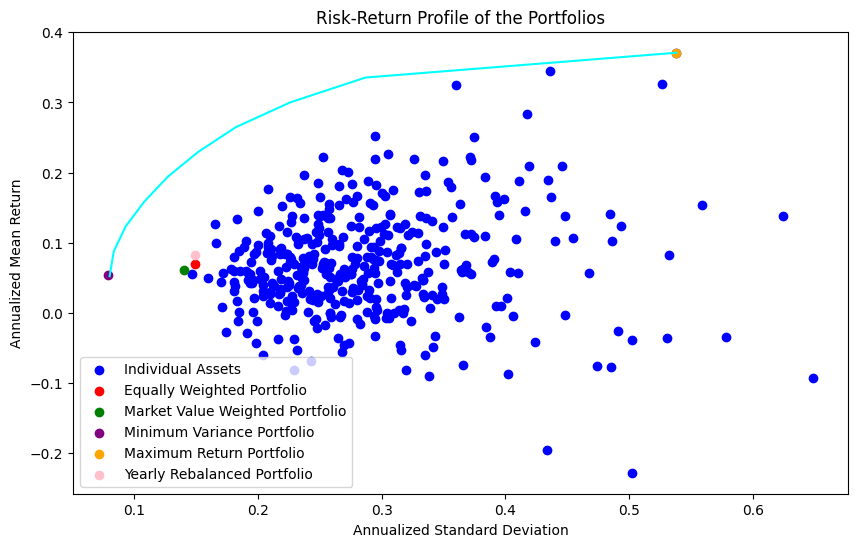

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(target_ann_std, target_ann_ret, color='cyan')
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance Portfolio')
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return Portfolio')
plt.scatter(reb_ann_std, reb_ann_ret, color='pink', label='Yearly Rebalanced Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.show()

In [94]:
# Install seaborn if not already installed
%pip install seaborn

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


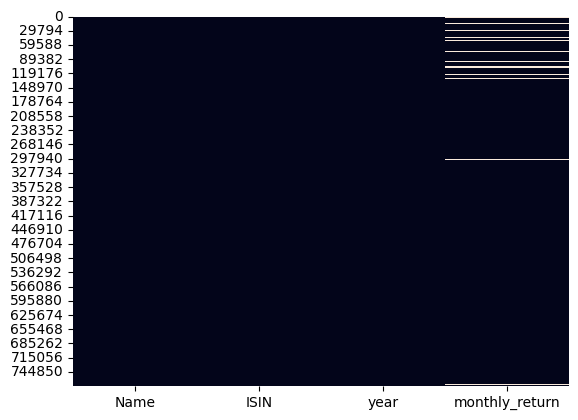

In [95]:
plt.figure()

sns.heatmap(monthly_return_melted.isnull(), cbar=False)
plt.show()